# ML Models for Failure Detection and Predictive Maintenance

<img src="pipeline.jpg" style="width:1200px;height:400px"/>

#### Outline
1. **Data Preparation and Preprocessing**
2. **Random Forest Model**
3. **Logistic Regression Model**
4. **MLP Model**
5. **Results and Evaluation**

In [1]:
# pip install imbalanced-learn
# pip install plotly

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score, matthews_corrcoef
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

### 1. Data Preparation and Preprocessing

#### About the data
The set includes different milling machines' features and their failure modes. 

*Data sources:*
1. **Available Predictive Maintenance Dataset (AI4I 2020):** please refer to https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020 <br> *Data set copyright notice: S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.*
2. **Collected data**

#### Data collection
##### Generate Synthetic Data with GPT
To supplement the AI4I 2020 dataset, synthetic data was generated using GPT. The synthetic data aimed to mimic the statistical properties and class distribution of the original dataset. Here’s a summary of the approach:

1. **Gaussian Mixture Model (GMM):**
    Separate GMM models were used to model the distribution of features for “Machine failure = 0” and “Machine failure = 1”.
    This ensured class-specific patterns were captured.

2. **Class Balance:**
    Synthetic data maintained the same failure-to-non-failure ratio as the original dataset.

3. **Feature Clipping and Normalization:**
    Generated data was clipped to the original feature ranges and normalized using the MinMaxScaler for consistency.
    
The generated dataset is now being integrated into the notebook for further analysis and model evaluation.

In [2]:
import os
import joblib
from openai import OpenAI

client = OpenAI(api_key='put_your_key')

In [3]:
# Load the pre-trained random forest model model
rf = joblib.load("random_forest_model.pkl")
print("Model loaded successfully.")
rf

Model loaded successfully.


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=5,
                       random_state=42)

In [4]:
dataset_url = "https://drive.google.com/file/d/1Q29I_biCMhpOOKQix5qHN2zgvizERSjL/view?usp=sharing"

# Format the prompt with explicit structure expectation
prompt = (
    f"Generate 10 rows of synthetic data for predictive maintenance based on these specifications. "
    f"Return the data as a list of dictionaries with the following ranges:\n"
    "- Air temperature [K]: 290-320\n"
    "- Process temperature [K]: 300-350\n"
    "- Rotational speed [rpm]: 1000-3000\n"
    "- Torque [Nm]: 20-80\n"
    "- Tool wear [min]: 0-300\n"
    "- Machine failure: 0 or 1\n\n"
    "Format each row as a dictionary like this:\n"
    "{'Air temperature [K]': value, 'Process temperature [K]': value, 'Rotational speed [rpm]': value, "
    "'Torque [Nm]': value, 'Tool wear [min]': value, 'Machine failure': value}"
)

In [5]:
import json

def generate_synthetic_data(prompt, n_samples=10):
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a data generation assistant. Return data in valid JSON format."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=1000,
        temperature=0.7,
        n=1  # Changed from n_samples as the API might not support multiple generations
    )
    
    synthetic_data = []
    try:
        # Parse the response as JSON instead of using eval()
        content = response.choices[0].message.content
        data = json.loads(content)
        if isinstance(data, list):
            synthetic_data.extend(data)
        else:
            synthetic_data.append(data)
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        print(f"Raw content: {content}")
    except Exception as e:
        print(f"Unexpected error: {e}")
        
    return pd.DataFrame(synthetic_data)

In [6]:
def test_synthetic_data_accuracy(model, synthetic_data):
    X_synthetic = synthetic_data.drop(columns=['Machine failure'])
    y_synthetic = synthetic_data['Machine failure']
    
    # Predict using the trained model
    y_pred = model.predict(X_synthetic)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_synthetic, y_pred) * 100
    return accuracy

In [7]:
def append_synthetic_data(base_dataset, synthetic_data, model, threshold=80):
    print("\n=== Debug Information ===")
    print("Base dataset columns:", base_dataset.columns.tolist())
    print("Synthetic data columns:", synthetic_data.columns.tolist())
    print("Model features:", model.feature_names_in_)
    
    # Create a copy to avoid modifying the original data
    synthetic_data = synthetic_data.copy()
    
    # Normalize column names
    synthetic_data.columns = synthetic_data.columns.str.strip()
    
    # Case-insensitive column mapping
    column_mapping = {}
    for model_feature in model.feature_names_in_:
        found = False
        for synthetic_col in synthetic_data.columns:
            if model_feature.lower() == synthetic_col.lower():
                column_mapping[synthetic_col] = model_feature
                found = True
                break
        if not found:
            raise ValueError(f"Required column '{model_feature}' not found in synthetic data")
    
    # Rename columns to match model features exactly
    synthetic_data = synthetic_data.rename(columns=column_mapping)
    
    # Reorder columns to match model features exactly
    synthetic_data = synthetic_data[model.feature_names_in_]
    
    # Verify column alignment
    if not all(synthetic_data.columns == model.feature_names_in_):
        raise ValueError("Column order mismatch after reordering")
    
    # Test accuracy
    accuracy = test_synthetic_data_accuracy(model, synthetic_data)
    print(f"\nAccuracy of synthetic data: {accuracy:.2f}%")
    
    if accuracy >= threshold:
        print("Appending synthetic data to the base dataset.")
        result = pd.concat([base_dataset, synthetic_data], ignore_index=True)
    else:
        print("Synthetic data rejected due to low accuracy.")
        result = base_dataset
    
    return result, accuracy

In [8]:
synthetic_data = generate_synthetic_data(prompt)

In [9]:
synthetic_data

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,297,324,1500,35,50,0
1,302,340,2000,50,100,1
2,310,333,2200,60,150,0
3,300,350,1000,25,200,1
4,315,310,2500,40,250,0
5,305,300,2800,70,50,0
6,320,330,2600,30,100,1
7,295,315,1400,45,300,0
8,312,320,1600,55,175,1
9,305,305,1800,80,150,0


In [10]:
# base_dataset = pd.read_csv("Machine-Failure-Dataset.csv")
# res, acc = append_synthetic_data(base_dataset, synthetic_data, rf, threshold=80)

In [11]:
# dataset = append_synthetic_data(dataset, synthetic_data, rf, threshold=80)

In [12]:
# dataset.to_csv("updated_dataset.csv", index=False)
# print("Updated dataset saved as 'updated_dataset.csv'")

#### Load the whole dataset: collected + AI4I 2020

In [13]:
# read csv file of data set
dataset = pd.read_csv("Machine-Failure-Dataset.csv")

# show first rows of data set
dataset.head(3)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


**The failure modes explained:**
- TWT (tool wear failure): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins.
- HDF (heat dissipation failure): if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm, the process fails.
- PWF (power failure): if this power required for the process is below 3500 W or above 9000 W, the process fails.
- OSF (overstrain failure): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant, the process fails. 
- RNF (random failures): each process has a chance of 0,1 % to fail regardless of its process parameters.

If at least one of the above failure modes is true, the process fails and the *machine failure* label is set to 1.

#### Explore the data

In [14]:
# drop UDI and Product ID columns
dataset.drop(['Product ID', 'UDI'], axis=1, inplace = True)

dataset.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


#### Distribution of failure modes

Text(0.5, 1.0, 'Failure mode per machine type')

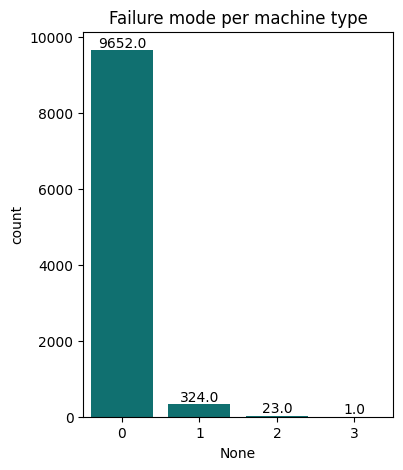

In [15]:
failure_modes = dataset.loc[:, ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Calculate the sum of the values in each row
rows_sum = failure_modes.sum(axis=1)

fig, ax = plt.subplots(figsize=(4, 5))
sns.countplot(x=rows_sum, ax=ax, color='#008080')

for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
    
ax.set_title('Failure mode per machine type')

<Axes: xlabel='Machine failure', ylabel='Count'>

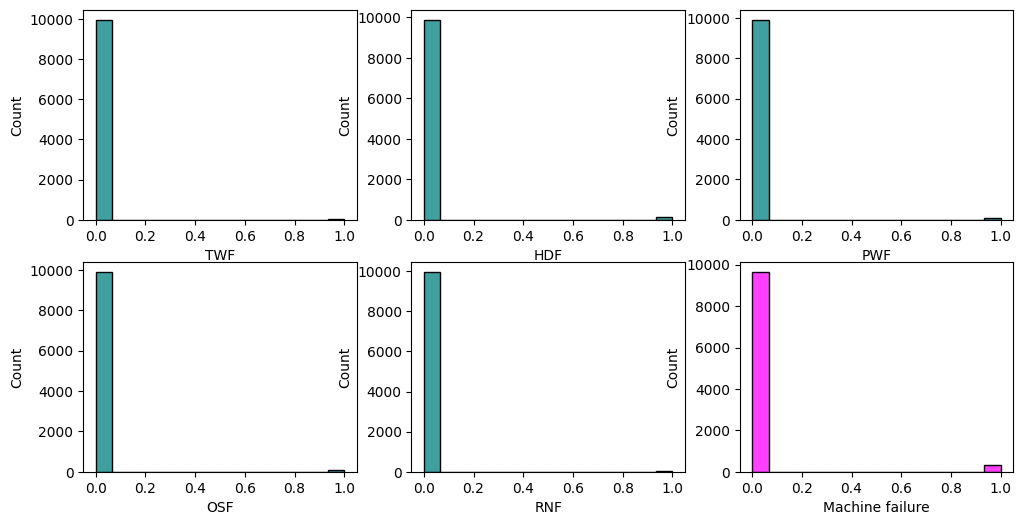

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i, col in enumerate(failure_modes):
    sns.histplot(dataset[col], ax=ax[i//3][i%3], color='#008080')

# Plot Machine failure in last subplot
sns.histplot(dataset['Machine failure'], ax=ax[1][2], color='#FF00FF')

So since the count of every single failure type is very small compared to the entire data set, we only consider the combined feature ***Machine failure***. The individual failure types are dropped.

In [17]:
# drop individual failure types
dataset.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

In [18]:
dataset.head(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0


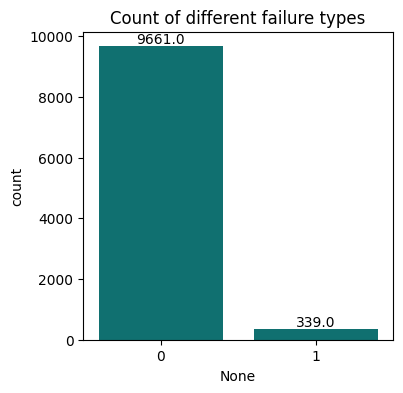

In [19]:
failure_types = dataset.loc[:, ['Machine failure']]

rows_sum = failure_types.sum(axis=1)

fig, ax = plt.subplots(figsize=(4, 4))
sns.countplot(x=rows_sum, ax=ax, color='#008080')
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
    ax.set_title('Count of different failure types')

#### Suggestion: Data Augmentation through a Synthetic Minority Over-sampling Technique (SMOTE)??
SMOTE is a method to over-sample minority classes. <br>
For more infos please refer to https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

In [20]:
smote = SMOTE(random_state=42)
data_resampled = smote.fit_resample(dataset[['Process temperature [K]','Torque [Nm]', 'Tool wear [min]']], 
                                    dataset['Machine failure'])

In [21]:
# data_resampled[0].describe()

In [22]:
# data_resampled[1]

#### Old vs New distribution: ELIMINATED

<Axes: xlabel='Machine failure', ylabel='Count'>

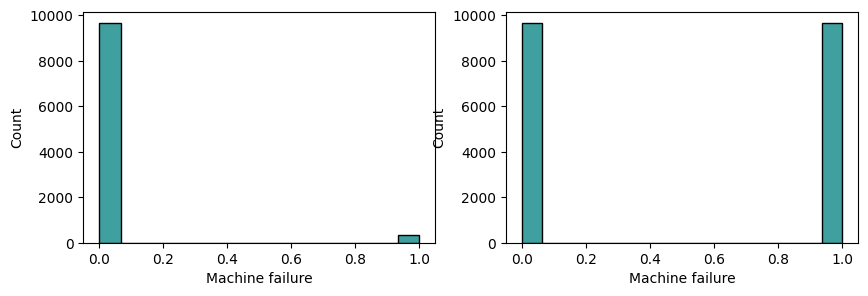

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.histplot(dataset['Machine failure'], ax=ax[0], color='#008080')
sns.histplot(data_resampled[1], ax=ax[1], color='#008080')

#### Handling Outliers
We calculate and handle the outliers for each attribute using IQR, which is the interquartile range.

In [24]:
excluded_columns = ['Type', 'Machine failure']

for col in dataset.columns:
    if col not in excluded_columns:
        # convert to float
        dataset[col] = dataset[col].astype(float)
        # calculate the IQR 
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = dataset[(dataset[col] <= (Q1 - 1.5 * IQR)) | (dataset[col] >= (Q3 + 1.5 * IQR))]
        if not outliers.empty:
          dataset.drop(outliers.index, inplace=True)

#### Density-Based Anomaly Detection (LOF)
The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

More infos: https://scikit-learn.org/1.5/auto_examples/neighbors/plot_lof_outlier_detection.html

In [25]:
# convert the 'type' column to numbers (float) for processing of the whole dataset as float
dataset['Type'].replace('L', 0, inplace=True)  # L = 0
dataset['Type'].replace('M', 1, inplace=True)  # M = 1
dataset['Type'].replace('H', 2, inplace=True)  # H = 2

In [26]:
# create the LOF model
model = LocalOutlierFactor(n_neighbors=5)

# use the model to predict the outlier scores for each row
scores = model.fit_predict(dataset)

# identify the outlier rows (those with a negative score) and remove them
outliers = dataset[scores == -1]

In [27]:
dataset['outlier_score'] = scores  # Add outlier scores as a column to the DataFrame

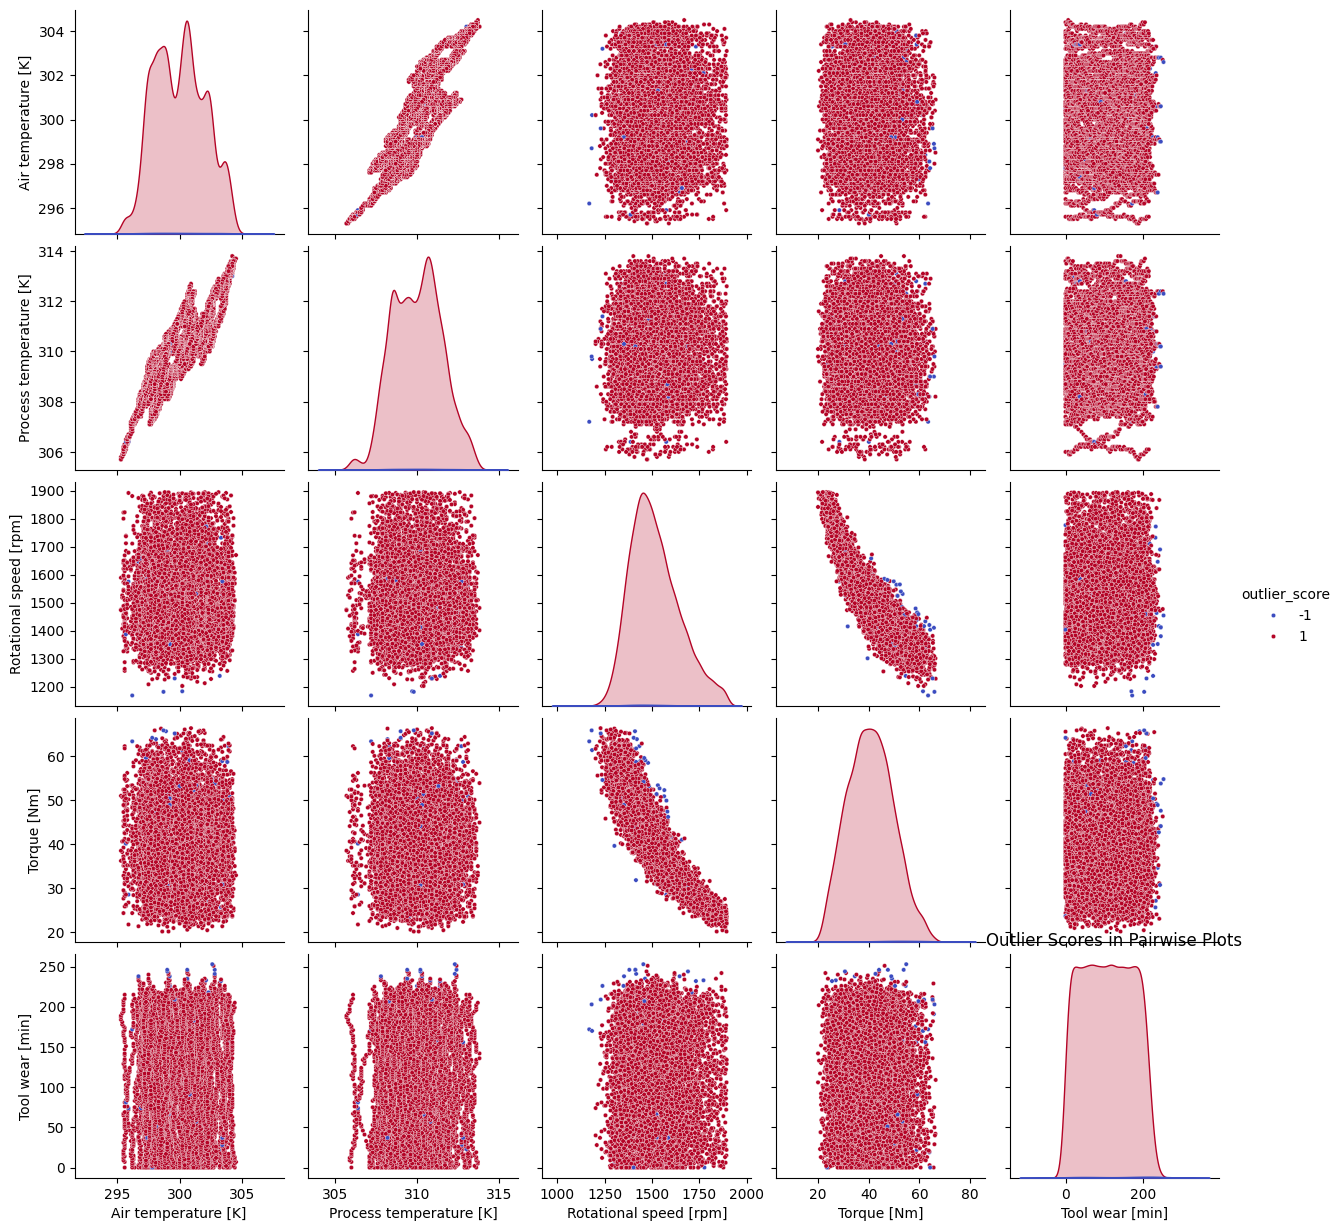

In [28]:
# Create a pairplot and color the points by outlier score
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'outlier_score']

sns.pairplot(dataset[features], hue='outlier_score', palette='coolwarm', plot_kws={'s': 10})
plt.title("Outlier Scores in Pairwise Plots")
plt.show()

In [29]:
dataset.drop(['outlier_score'], axis=1, inplace=True)

if not outliers.empty:
    dataset.drop(outliers.index, inplace=True)

# shape after removing the outliers
dataset.shape 

(9485, 7)

#### Data normalization

In [30]:
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

scaler = MinMaxScaler()
dataset[features] = scaler.fit_transform(dataset[features])

# Check normalized Values
dataset[features].head(3)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.304348,0.358025,0.503608,0.490281,0.000000
1,0.315217,0.370370,0.297258,0.565875,0.011952
2,0.304348,0.345679,0.427128,0.632829,0.019920


#### Correlation between features
There is a strong correlation between:
- Process and air temperature: We can drop one of the temperatures, we will drop the air temperature later.
- Torque and rotational speed: the torque to rotational speed difference might be a indication of a failure, so we'll keep both.

<Axes: >

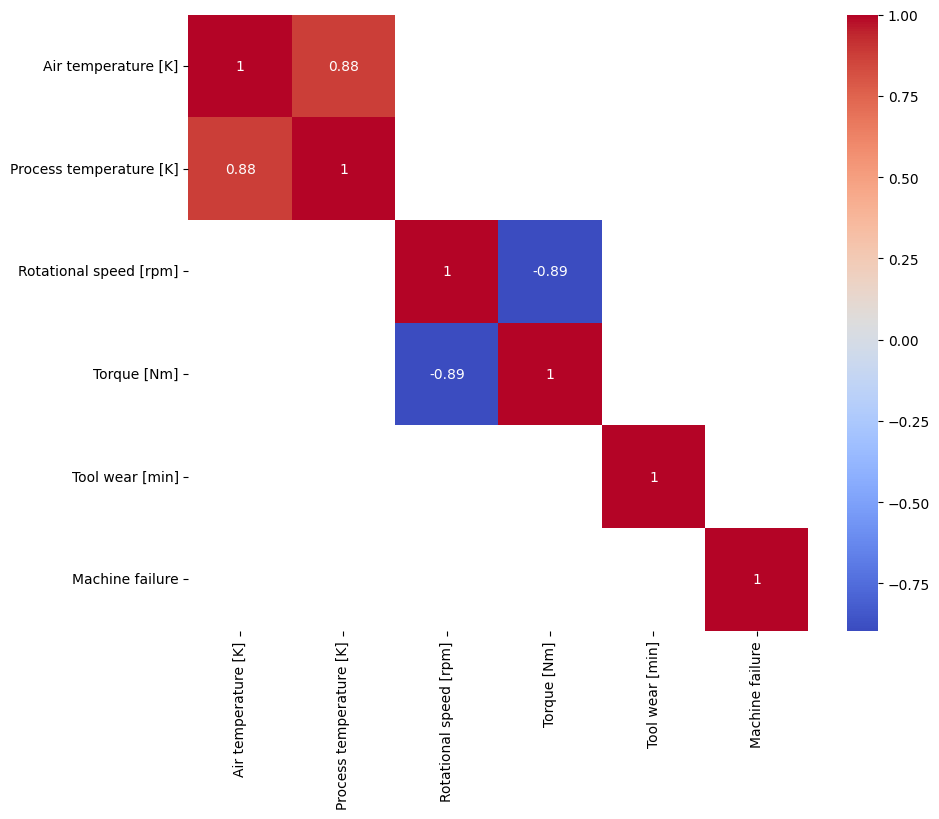

In [31]:
dataset.drop(['Type'],axis=1,inplace=True) # we don't need it, just note it is over dominated by type L

threshold = 0.3
correlation = dataset.corr()
matrix = correlation.where((abs(correlation) >= threshold)).isna()
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), cmap="coolwarm", annot=True, mask=matrix)

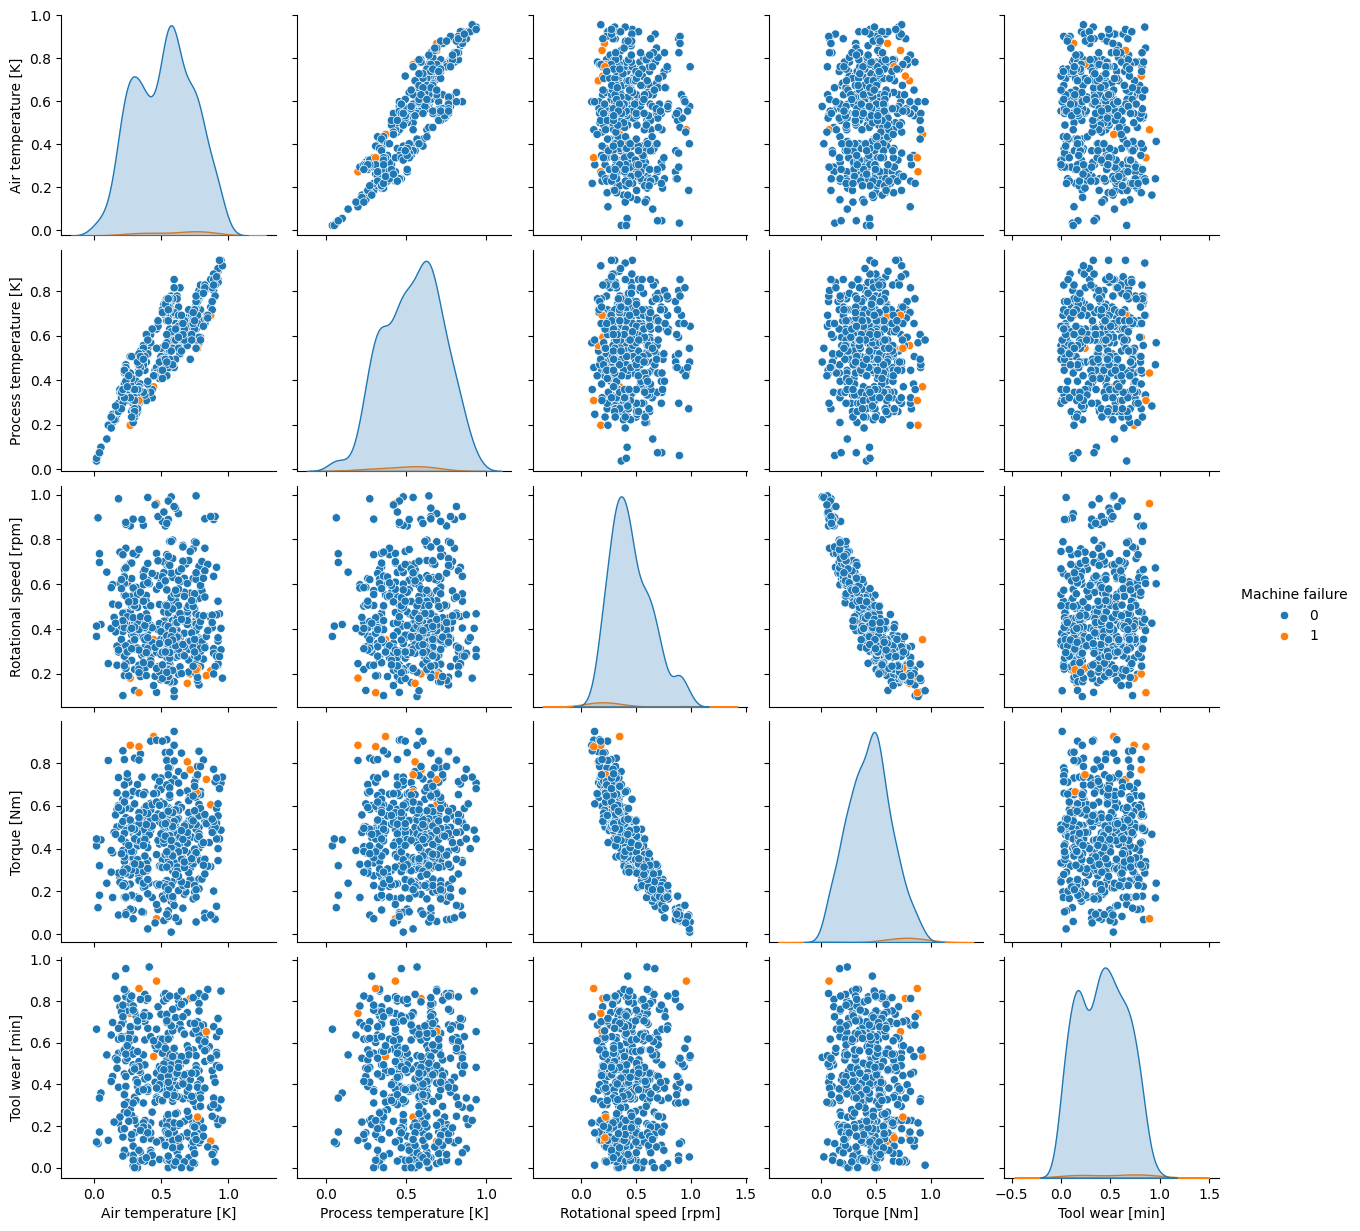

In [32]:
#### Scatter plot
sns.pairplot(dataset.sample(frac=0.05), hue='Machine failure')

#### Feature selection
We want to determine the best features that represent the dataset to use them as training inputs.

Therefore we perform a **statistical univariate test**: tests that involve one dependent variable.

In [33]:
best_features = SelectKBest(score_func=chi2,k='all')

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Feature scores",
                  height=500,
                  showlegend=False,
                 )

fig.show()

In [34]:
# features = ['Air temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
features = feature_score.feature.tolist()
target = 'Machine failure'

# Split data
X = dataset[features]
Y = dataset[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state=42 , stratify=Y )

### 2. Random Forest Model

In [35]:
# Initialize
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= "balanced", min_samples_split=5, min_samples_leaf=10, max_depth=10)

#### Model training

In [36]:
rf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=5,
                       random_state=42)

#### Model predictions

In [37]:
# Predictions of random forest model
Y_pred_rf = rf.predict(X_test)

# Generate prediction for training data
Y_pred_rf_train = rf.predict(X_train)

### 3. Logistic Regression Model

In [38]:
# Initialize
lr = LogisticRegression(random_state=42, class_weight= "balanced")

#### Model training

In [39]:
# Train
lr.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', random_state=42)

#### Model predictions

In [40]:
# Predictions of logistic regression model
Y_pred_lr = lr.predict(X_test)

# Generate prediction for training data
Y_pred_lr_train = lr.predict(X_train)

### 4. Multilayer Perceptron

#### Model structure
The selected MLP contains two hidden layers, each with 100 neurons. 
ReLU is selected as an activation function.
Adam optimizer is used to optimize the weights during training.
The model then fits training data and their corresponding labels.


<img src="MLPStructure.png" style="width:550px;height:400px"/>

#### Model Training

In [41]:
import time
start = time.time()
model = MLPClassifier(hidden_layer_sizes = (100,100,), 
                      activation='relu', 
                      solver='adam',
                      batch_size=2000,
                      verbose=0).fit(X_train, Y_train)
end_train = time.time()
print('Training time in seconds:', end_train-start)

Training time in seconds: 8.136610507965088


#### Model Predictions

In [42]:
Y_pred_mlp = model.predict(X_test)
end_predict = time.time()

### 5. Results and Evaluation

#### Random Forest Model results

Random Forest Confusion Matrix for test data set: 



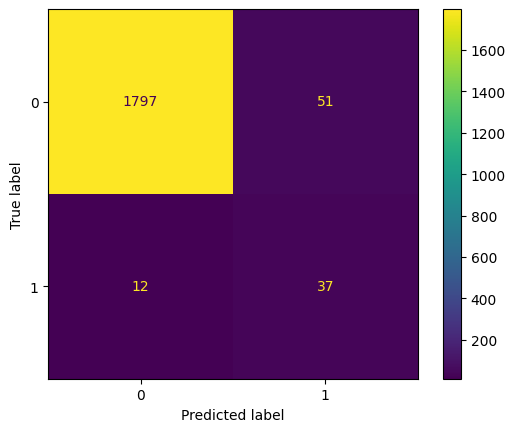

In [43]:
# Concfusion Matrix
# cm_rf_train = confusion_matrix(Y_train, Y_pred_rf_train)
# print("Random Forest Confusion Matrix for training data set: \n", cm_rf_train)

cm_rf = confusion_matrix(Y_test, Y_pred_rf)
print("Random Forest Confusion Matrix for test data set: \n")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= [0,1])
disp.plot()
plt.show()

In [44]:
# Classification Report
# cr_rf_train = classification_report(Y_train, Y_pred_rf_train)
# print("Random Forest Classification Report for training data set: \n", cr_rf_train)

cr_rf = classification_report(Y_test, Y_pred_rf)
print("Random Forest Classification Report for test data set: \n", cr_rf)

Random Forest Classification Report for test data set: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1848
           1       0.42      0.76      0.54        49

    accuracy                           0.97      1897
   macro avg       0.71      0.86      0.76      1897
weighted avg       0.98      0.97      0.97      1897



#### Logistic Regression Model results

Logistic Regression Confusion Matrix for test data set: 



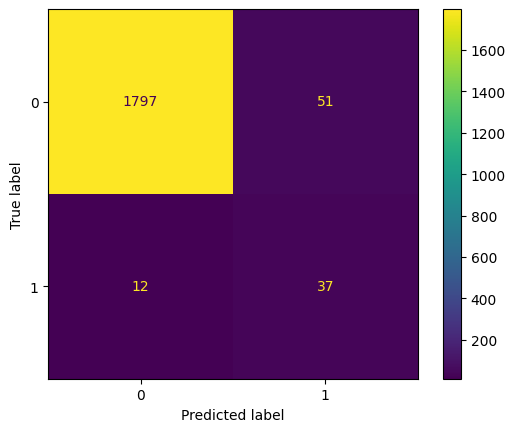

In [45]:
# Confusion Matrix
# cm_lr_train = confusion_matrix(Y_train, Y_pred_lr_train)
# print("Logistic Regression Confusion Matrix for training data set: \n", cm_lr_train)

cm_lr = confusion_matrix(Y_test, Y_pred_lr)
print("Logistic Regression Confusion Matrix for test data set: \n")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= [0,1])
disp.plot()
plt.show()

In [46]:
# Classification Report
# cr_lr_train = classification_report(Y_train, Y_pred_lr_train)
# print("Logistic Regression Classification Report for training data set: \n", cr_lr_train)

cr_lr = classification_report(Y_test, Y_pred_lr)
print("Logistic Regression Classification Report for test data set: \n", cr_lr)

Logistic Regression Classification Report for test data set: 
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1848
           1       0.10      0.82      0.18        49

    accuracy                           0.81      1897
   macro avg       0.55      0.82      0.54      1897
weighted avg       0.97      0.81      0.88      1897



#### MLP Model results

Logistic Regression Confusion Matrix for test data set: 



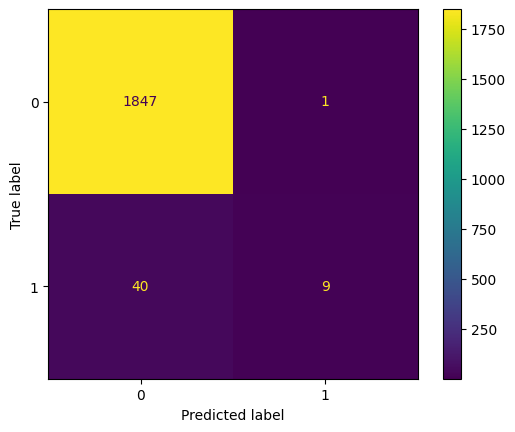

In [47]:
cm_mlp = confusion_matrix(Y_test, Y_pred_mlp)
print("Logistic Regression Confusion Matrix for test data set: \n")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels= [0,1])
disp.plot()
plt.show()

In [48]:
# Classification Report

cr_mlp = classification_report(Y_test, Y_pred_mlp)
print("Logistic Regression Classification Report for test data set: \n", cr_mlp)

Logistic Regression Classification Report for test data set: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1848
           1       0.90      0.18      0.31        49

    accuracy                           0.98      1897
   macro avg       0.94      0.59      0.65      1897
weighted avg       0.98      0.98      0.97      1897



#### Comparison: ROC Curve for random forest VS logistic regression

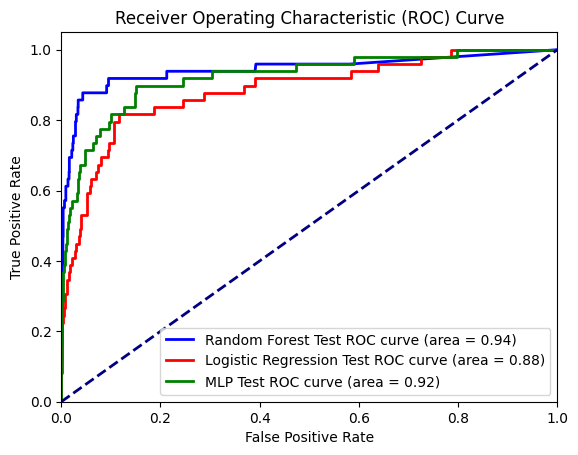

In [54]:
# Compute ROC curve and ROC area for Random Forest
# fpr_rf_train, tpr_rf_train, _ = roc_curve(Y_train, rf.predict_proba(X_train)[:, 1])
# roc_auc_rf_train = auc(fpr_rf_train, tpr_rf_train)

fpr_rf_test, tpr_rf_test, _ = roc_curve(Y_test, rf.predict_proba(X_test)[:, 1])
roc_auc_rf_test = auc(fpr_rf_test, tpr_rf_test)

# Compute ROC curve and ROC area for Logistic Regression
# fpr_lr_train, tpr_lr_train, _ = roc_curve(Y_train, lr.predict_proba(X_train)[:, 1])
# roc_auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

fpr_lr_test, tpr_lr_test, _ = roc_curve(Y_test, lr.predict_proba(X_test)[:, 1])
roc_auc_lr_test = auc(fpr_lr_test, tpr_lr_test)

# Compute ROC curve and ROC area for MLP
fpr_mlp_test, tpr_mlp_test, _ = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
roc_auc_mlp_test = auc(fpr_mlp_test, tpr_mlp_test)

# Plot ROC curves
plt.figure()

# Plot ROC for Random Forest
# plt.plot(fpr_rf_train, tpr_rf_train, color='darkorange', lw=2, label='Random Forest Train ROC curve (area = %0.2f)' % roc_auc_rf_train)
plt.plot(fpr_rf_test, tpr_rf_test, color='blue', lw=2, label='Random Forest Test ROC curve (area = %0.2f)' % roc_auc_rf_test)

# Plot ROC for Logistic Regression
# plt.plot(fpr_lr_train, tpr_lr_train, color='green', lw=2, label='Logistic Regression Train ROC curve (area = %0.2f)' % roc_auc_lr_train)
plt.plot(fpr_lr_test, tpr_lr_test, color='red', lw=2, label='Logistic Regression Test ROC curve (area = %0.2f)' % roc_auc_lr_test)

# Plot ROC for MLP
plt.plot(fpr_mlp_test, tpr_mlp_test, color='green', lw=2, label='MLP Test ROC curve (area = %0.2f)' % roc_auc_mlp_test)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Conclusion

In [50]:
# MCC: Matthews Correlation Coefficient

model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score'])

# Summary of results from random forest
accuracy = accuracy_score(Y_test, Y_pred_rf)
recall = recall_score(Y_test, Y_pred_rf, average='weighted')
precision = precision_score(Y_test, Y_pred_rf, average='weighted')
f1s = f1_score(Y_test, Y_pred_rf, average='weighted')
MCC = matthews_corrcoef(Y_test, Y_pred_rf)

model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC]

# Summary of results from logistic regression
accuracy = accuracy_score(Y_test, Y_pred_lr)
recall = recall_score(Y_test, Y_pred_lr, average='weighted')
precision = precision_score(Y_test, Y_pred_lr, average='weighted')
f1s = f1_score(Y_test, Y_pred_lr, average='weighted')
MCC = matthews_corrcoef(Y_test, Y_pred_lr)

model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s,MCC]

# Summary of results from MLP
accuracy = accuracy_score(Y_test, Y_pred_mlp)
recall = recall_score(Y_test, Y_pred_mlp, average='weighted')
precision = precision_score(Y_test, Y_pred_mlp, average='weighted')
f1s = f1_score(Y_test, Y_pred_mlp, average='weighted')
MCC = matthews_corrcoef(Y_test, Y_pred_mlp)

model_performance.loc['MLP'] = [accuracy, recall, precision, f1s,MCC]


model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'MCC score': '{:.2%}'
                                                                     })

,Accuracy,Recall,Precision,F1-Score,MCC score
Random Forest,96.68%,96.68%,97.86%,97.13%,54.87%
Logistic,81.39%,81.39%,97.11%,87.66%,24.88%
MLP,97.84%,97.84%,97.68%,97.14%,40.12%
